# Transfer Learning with UC-Merced Dataset

- For Feature Extraction, you freeze the network.

    - When we used `requires_grad = False`, we are freezing the network

- For Fine Tunning, you change the last layer `model.classifier[1] = nn.Conv2d(512, nb_class)`



- **Finetuning the ConvNet**: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
    - `model.classifier[1] = nn.Conv2d(512, nb_class)`
    - By default, the last layer of classifier, there are 1000 classes, but we have to replace `nb_classes` by the amount of classes we have in our dataset.

- **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained
    -  We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward()
    

In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

#loading models

import torchvision.models as models


In [ ]:
#setting the path of the jupyter notebook
import os
os.chdir('/content/drive/MyDrive/image_processing/deep_learning')
os.getcwd()

'/content/drive/MyDrive/image_processing/deep_learning'

In [ ]:
#!unzip './data/transfer_6394502_files_0a0e2750/UCMerced.zip'

In [ ]:
#@title Defining Functions

def show_images(img):
    #img = (img - img.min())/(img.max()-img.min())
    npimg = img.numpy()
    plt.figure(figsize=(8*4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


import time
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_time_elapsed = epoch_end_time - epoch_start_time
            print(f'Epoch {epoch} took {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s')

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model



def test_model(model, criterion, dataloader, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {accuracy:.4f}')
    return total_loss, accuracy

In [ ]:
# Step 1: Set the transforms and resizing the images to 256*256
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


In [ ]:
# Step 2: Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(os.getcwd(), 'UCMerced/train'), transform=transform)

val_dataset = datasets.ImageFolder(root=os.path.join(os.getcwd(), 'UCMerced/val'), transform=transform)

test_dataset = datasets.ImageFolder(root=os.path.join(os.getcwd(), 'UCMerced/test'), transform=transform)

# Step 3: Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [1]:
dataloaders = {
    'train':train_loader,
    'val':val_loader,
    'test':test_loader
}

dataset_sizes = {
    'train':len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)

}

NameError: ignored

In [ ]:
#-- An example training data (Tensor+label)
print(test_dataset[0])
print(test_dataset[0][0].shape)

(tensor([[[0.5333, 0.5725, 0.5373,  ..., 0.4902, 0.5647, 0.5647],
         [0.4314, 0.4549, 0.5373,  ..., 0.4078, 0.4275, 0.4667],
         [0.4824, 0.4196, 0.3686,  ..., 0.4275, 0.4275, 0.3608],
         ...,
         [0.6275, 0.5922, 0.4902,  ..., 0.4667, 0.5882, 0.6078],
         [0.4549, 0.5843, 0.6314,  ..., 0.4039, 0.3137, 0.4627],
         [0.3922, 0.3882, 0.5294,  ..., 0.4275, 0.3725, 0.3922]],

        [[0.5176, 0.5529, 0.5255,  ..., 0.4667, 0.5412, 0.5451],
         [0.4118, 0.4275, 0.5098,  ..., 0.4000, 0.4118, 0.4471],
         [0.4784, 0.4078, 0.3451,  ..., 0.4353, 0.4353, 0.3569],
         ...,
         [0.6235, 0.6118, 0.5255,  ..., 0.4314, 0.5725, 0.6235],
         [0.4235, 0.5686, 0.6353,  ..., 0.3765, 0.2863, 0.4431],
         [0.3647, 0.3569, 0.5098,  ..., 0.4471, 0.3647, 0.3569]],

        [[0.4941, 0.5333, 0.5059,  ..., 0.4510, 0.5216, 0.5216],
         [0.3961, 0.4196, 0.5059,  ..., 0.3882, 0.3961, 0.4314],
         [0.4627, 0.4039, 0.3529,  ..., 0.4118, 0.4118, 0

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


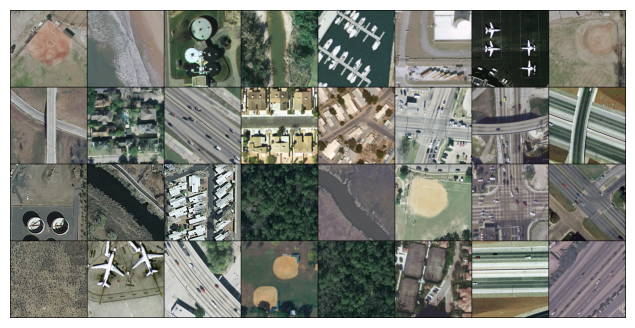

In [ ]:
# Step 4: Visualizing the data
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(make_grid(images))

In [ ]:
# Step 5: Activating CUDA
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1. Fine Tunning SqueezeNet

In [ ]:
model_ft= models.squeezenet1_1(weights='IMAGENET1K_V1').to(device) #loaded the weight pre-defined


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 50.8MB/s]


In [ ]:
model_ft.classifier[1]

Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
model_ft.classifier[1] = nn.Conv2d(512, 21, kernel_size=(1, 1)) #img size / number of classes / kernel size

model_ft.num_classes = 21


In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 2.4865 Acc: 0.2371
val Loss: 1.7005 Acc: 0.4794
Epoch 0 took 6m 47s

Epoch 1/39
----------
train Loss: 1.2210 Acc: 0.5971
val Loss: 0.8580 Acc: 0.7254
Epoch 1 took 0m 12s

Epoch 2/39
----------
train Loss: 0.7313 Acc: 0.7600
val Loss: 0.9071 Acc: 0.7079
Epoch 2 took 0m 10s

Epoch 3/39
----------
train Loss: 0.5333 Acc: 0.8305
val Loss: 0.6728 Acc: 0.7683
Epoch 3 took 0m 8s

Epoch 4/39
----------
train Loss: 0.3934 Acc: 0.8838
val Loss: 0.5991 Acc: 0.8016
Epoch 4 took 0m 8s

Epoch 5/39
----------
train Loss: 0.3424 Acc: 0.8790
val Loss: 0.5873 Acc: 0.8190
Epoch 5 took 0m 8s

Epoch 6/39
----------
train Loss: 0.3847 Acc: 0.8648
val Loss: 0.5896 Acc: 0.8302
Epoch 6 took 0m 8s

Epoch 7/39
----------
train Loss: 0.1628 Acc: 0.9514
val Loss: 0.3405 Acc: 0.8937
Epoch 7 took 0m 8s

Epoch 8/39
----------
train Loss: 0.0889 Acc: 0.9790
val Loss: 0.3153 Acc: 0.9000
Epoch 8 took 0m 8s

Epoch 9/39
----------
train Loss: 0.0726 Acc: 0.9829
val Loss: 0.3071 Acc: 0.90

In [ ]:
#test
test_model(model_ft, criterion, dataloaders['test'], device='cuda')

Test Loss: 0.2919 Acc: 0.8929


(0.2918919841448466, tensor(0.8929, device='cuda:0', dtype=torch.float64))

# 2. Feature Extraction SqueezeNet

In [ ]:
model_squeeze_ft = models.squeezenet1_1(weights='IMAGENET1K_V1')
for param in model_squeeze_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_squeeze_ft.classifier[1]=nn.Conv2d(512,21,kernel_size=(1,1))
model_squeeze_ft.num_classes=21

model_squeeze_ft = model_squeeze_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_squeeze_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
#training
model_squeeze_ft = train_model(model_squeeze_ft, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 2.5507 Acc: 0.2438
val Loss: 1.6240 Acc: 0.5381
Epoch 0 took 0m 7s

Epoch 1/39
----------
train Loss: 1.1846 Acc: 0.6552
val Loss: 0.9732 Acc: 0.6873
Epoch 1 took 0m 7s

Epoch 2/39
----------
train Loss: 0.8015 Acc: 0.7657
val Loss: 0.7682 Acc: 0.7460
Epoch 2 took 0m 7s

Epoch 3/39
----------
train Loss: 0.6073 Acc: 0.8162
val Loss: 0.6271 Acc: 0.7968
Epoch 3 took 0m 7s

Epoch 4/39
----------
train Loss: 0.4989 Acc: 0.8524
val Loss: 0.5842 Acc: 0.8175
Epoch 4 took 0m 7s

Epoch 5/39
----------
train Loss: 0.4317 Acc: 0.8733
val Loss: 0.5472 Acc: 0.8127
Epoch 5 took 0m 7s

Epoch 6/39
----------
train Loss: 0.3961 Acc: 0.8895
val Loss: 0.5253 Acc: 0.8238
Epoch 6 took 0m 7s

Epoch 7/39
----------
train Loss: 0.3414 Acc: 0.9162
val Loss: 0.4947 Acc: 0.8429
Epoch 7 took 0m 7s

Epoch 8/39
----------
train Loss: 0.3392 Acc: 0.9181
val Loss: 0.4898 Acc: 0.8397
Epoch 8 took 0m 7s

Epoch 9/39
----------
train Loss: 0.3283 Acc: 0.9257
val Loss: 0.4871 Acc: 0.8444


In [ ]:
#testing


test_model(model_squeeze_ft, criterion, dataloaders['test'], device = 'cuda')

Test Loss: 0.4824 Acc: 0.8524


(0.4824404659725371, tensor(0.8524, device='cuda:0', dtype=torch.float64))

# 3. Fine Tunning ResNet18

# 4. Feature Extraction ResNet18

In [ ]:
model_conv = models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 21)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
train Loss: 2.9079 Acc: 0.1533
val Loss: 2.4714 Acc: 0.3381
Epoch 0 took 0m 8s

Epoch 1/39
----------
train Loss: 2.1822 Acc: 0.4876
val Loss: 1.8140 Acc: 0.6381
Epoch 1 took 0m 8s

Epoch 2/39
----------
train Loss: 1.6546 Acc: 0.6705
val Loss: 1.4411 Acc: 0.7429
Epoch 2 took 0m 7s

Epoch 3/39
----------
train Loss: 1.3243 Acc: 0.7895
val Loss: 1.1930 Acc: 0.8095
Epoch 3 took 0m 8s

Epoch 4/39
----------
train Loss: 1.1132 Acc: 0.8210
val Loss: 1.0349 Acc: 0.8159
Epoch 4 took 0m 7s

Epoch 5/39
----------
train Loss: 0.9557 Acc: 0.8543
val Loss: 0.9083 Acc: 0.8381
Epoch 5 took 0m 8s

Epoch 6/39
----------
train Loss: 0.8364 Acc: 0.8857
val Loss: 0.8150 Acc: 0.8619
Epoch 6 took 0m 8s

Epoch 7/39
----------
train Loss: 0.7868 Acc: 0.8971
val Loss: 0.8087 Acc: 0.8667
Epoch 7 took 0m 8s

Epoch 8/39
----------
train Loss: 0.7598 Acc: 0.9190
val Loss: 0.7982 Acc: 0.8810
Epoch 8 took 0m 7s

Epoch 9/39
----------
train Loss: 0.7458 Acc: 0.9152
val Loss: 0.7851 Acc: 0.8810


In [ ]:
#testing


test_model(model_conv, criterion, dataloaders['test'], device = 'cuda')

Test Loss: 0.7958 Acc: 0.8762


(0.7958320912860689, tensor(0.8762, device='cuda:0', dtype=torch.float64))

# 5. From Scratch with LaNet

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet5, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)

        #-- fully connected layers
        self.fc1 = nn.Linear(120*28*28, 84)
        self.fc2 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits


In [ ]:

# Initialize the loss function
lossF = nn.CrossEntropyLoss()

In [ ]:
#optimization loop
#Each epoch consists of two main parts:

#The Train Loop - iterate over the training dataset and try to converge to optimal parameters.
def train_epoch(model, optimizer, loss_func, dataloader, device):
  model.train()
  train_correct = 0
  train_loss = []
  for x_train_batch, y_train_batch in dataloader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model(x_train_batch) # forward pass

    loss = lossF(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch.cpu())
    train_loss.append(loss.item()/len(x_train_batch))

  train_accuracy = train_correct/len(dataloader.dataset)
  return train_loss, train_accuracy


#The Validation Loop - iterate over the validation dataset to check if model performance is improving.
def val_epoch(model, loss_func, dataloader, device):
  model.eval()
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += lossF(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch.cpu())
  val_loss = tmp_val_loss/len(dataloader.dataset) # compute the average loss
  val_accuracy = val_correct/len(dataloader.dataset)

  return val_loss, val_accuracy


In [ ]:
import time
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = LeNet5(3, 21)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
min_val_loss = np.Inf

for e in range(epochs):
  start_time = time.time()
  epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, lossF, train_loader, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(model, lossF, val_loader, device)

  end_time = time.time()
  epoch_time = end_time - start_time
  print(f'Epoch {e} took {epoch_time} seconds')

  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)


Epoch 0 took 7.12268853187561 seconds
Epoch 1 took 7.562880754470825 seconds
Epoch 2 took 6.85834527015686 seconds
Epoch 3 took 7.346460342407227 seconds
Epoch 4 took 7.057098388671875 seconds
Epoch 5 took 7.569038391113281 seconds
Epoch 6 took 7.276607990264893 seconds
Epoch 7 took 7.439345836639404 seconds
Epoch 8 took 7.909975290298462 seconds
Epoch 9 took 7.298806667327881 seconds
Epoch 10 took 7.352891683578491 seconds
Epoch 11 took 7.081433534622192 seconds
Epoch 12 took 7.428408861160278 seconds
Epoch 13 took 7.013987064361572 seconds
Epoch 14 took 7.63078761100769 seconds
Epoch 15 took 6.948267698287964 seconds
Epoch 16 took 7.804520845413208 seconds
Epoch 17 took 7.000066518783569 seconds
Epoch 18 took 7.6262595653533936 seconds
Epoch 19 took 6.913491249084473 seconds
Epoch 20 took 7.807262420654297 seconds
Epoch 21 took 7.037252187728882 seconds
Epoch 22 took 7.473241806030273 seconds
Epoch 23 took 7.257179260253906 seconds
Epoch 24 took 7.396972179412842 seconds
Epoch 25 too

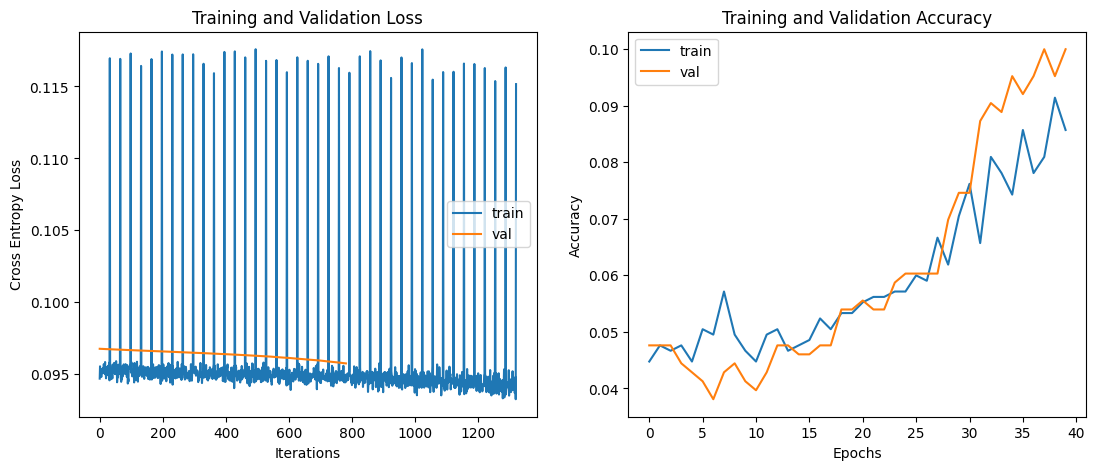

In [ ]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(val_loader),len(val_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")

In [ ]:
model5 = LeNet5(3, 21)
count_parameters(model5)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
| conv3.weight |   48000    |
|  conv3.bias  |    120     |
|  fc1.weight  |  7902720   |
|   fc1.bias   |     84     |
|  fc2.weight  |    1764    |
|   fc2.bias   |     21     |
+--------------+------------+
Total Trainable Params: 7955581


In [ ]:
#Save model
model = LeNet5(3,21)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
conv3.weight 	 torch.Size([120, 16, 5, 5])
conv3.bias 	 torch.Size([120])
fc1.weight 	 torch.Size([84, 94080])
fc1.bias 	 torch.Size([84])
fc2.weight 	 torch.Size([21, 84])
fc2.bias 	 torch.Size([21])


| Metric                         | SqueezeNet Fine Tuning | SqueezeNet Feature Extraction | ResNet Fine Tuning | ResNet Feature Extraction | Scratch              |
|--------------------------------|------------------------|-------------------------------|--------------------|-----------------------------|----------------------|
| Avg. Per Epoch                 | 8s                     | [value_fe_squeezenet]         | [value_ft_resnet]  | 8s                          | [value_scratch]      |
| Best Validation Set Accuracy   | 0.912                  | [accuracy_fe_squeezenet]     | [accuracy_ft_resnet] | 0.887                       | [accuracy_scratch]   |
| Test Set Accuracy              | 0.900                  | [test_accuracy_fe_squeezenet] | [test_accuracy_ft_resnet] | 0.862                       | [test_accuracy_scratch] |
| Epoch with Maximum Time        | 1st epoch - 7min       | [epoch_max_time_fe_squeezenet] | [epoch_max_time_ft_resnet] | 1st epoch - 12min           | [epoch_max_time_scratch] |
